I want to try to figure out a way to do a Lagrangian approach in Python.
In Mathematica I'd define the Lagrangian and then do the Euler Lagrange equation:
$$\frac{\partial L}{\partial x_i}-\frac{d}{dt}\frac{\partial L}{\partial \dot{x}_i}=0$$
for all the variables $x_i$. In this notebook I'm going to try to basically do the same thing.

In [1]:
import sympy as sym
t=sym.Symbol('t')
theta = sym.Function('theta')(t)
phi = sym.Function('phi')(t)
beta = sym.Function('beta')(t)
L1,L2,L3,m1,m2,m3,g = sym.symbols('L1 L2 L3 m1 m2 m3 g') 
x1 = L1*sym.sin(theta)
x2 = x1 + L2*sym.sin(phi)
x3 = x2 + L3*sym.sin(beta)
y1 = -L1*sym.cos(theta)
y2 = y1 - L2*sym.cos(phi)
y3 = y2 - L3*sym.cos(beta)
V = m1*g*y1 + m2*g*y2 + m3*g*y3
T = (m1*(sym.diff(x1,t)**2+sym.diff(y1,t)**2)/2 + (m2*(sym.diff(x2,t)**2 + sym.diff(y2,t)**2)/2) + (m3*(sym.diff(x3,t)**2 + sym.diff(y3,t)**2)/2)) 
L = T-V
L

L1*g*m1*cos(theta(t)) - g*m2*(-L1*cos(theta(t)) - L2*cos(phi(t))) - g*m3*(-L1*cos(theta(t)) - L2*cos(phi(t)) - L3*cos(beta(t))) + m1*(L1**2*sin(theta(t))**2*Derivative(theta(t), t)**2 + L1**2*cos(theta(t))**2*Derivative(theta(t), t)**2)/2 + m2*((L1*sin(theta(t))*Derivative(theta(t), t) + L2*sin(phi(t))*Derivative(phi(t), t))**2 + (L1*cos(theta(t))*Derivative(theta(t), t) + L2*cos(phi(t))*Derivative(phi(t), t))**2)/2 + m3*((L1*sin(theta(t))*Derivative(theta(t), t) + L2*sin(phi(t))*Derivative(phi(t), t) + L3*sin(beta(t))*Derivative(beta(t), t))**2 + (L1*cos(theta(t))*Derivative(theta(t), t) + L2*cos(phi(t))*Derivative(phi(t), t) + L3*cos(beta(t))*Derivative(beta(t), t))**2)/2

That's pretty ugly, but sympy handles it fine. Next is to do the E-L stuff (note I've used the KE as a shortcut to the power equation to do friction)

In [2]:
theta_equation=sym.diff(L,theta)-sym.diff(L,theta.diff(t),t)-0.2*sym.diff(T,theta.diff(t))
phi_equation = sym.diff(L, phi) - sym.diff(L, phi.diff(t), t)-0.2*sym.diff(T,phi.diff(t))
beta_equation = sym.diff(L, beta) - sym.diff(L, beta.diff(t), t)-0.2*sym.diff(T,beta.diff(t))

Ok, now we've got the equations we need. Unfortunately, in order to integrate them using odeint we need to turn most of the variables into dummy variables. I found this on a stackexchange site:

In [3]:
def dummify_undefined_functions(expr): 
    mapping = {} # replace all Derivative terms 
    for der in expr.atoms(sym.Derivative): 
        f_name = der.expr.func.__name__ 
        var_names = [var.name for var in der.variables] 
        name = "d%s_d%s" % (f_name, 'd'.join(var_names)) 
        mapping[der] = sym.Symbol(name) 
        # replace undefined functions 
        from sympy.core.function import AppliedUndef 
        for f in expr.atoms(AppliedUndef): 
            f_name = f.func.__name__ 
            mapping[f] = sym.Symbol(f_name) 
    return expr.subs(mapping)

That function can replace something like Derivative(theta(t), t, t) with dtheta_dtdt:

In [4]:
theta_equation_dummified=dummify_undefined_functions(theta_equation)
phi_equation_dummified=dummify_undefined_functions(phi_equation)
beta_equation_dummified=dummify_undefined_functions(beta_equation)

Ok, so that's the three equations. Now we need to solve them for the second derivatives because odeint needs those to be on the left hand side.

**Note that this cell (below) takes ~25 seconds on my machine. It's by far the longest part of all of this. I'd love some help in making this faster. The second derivates all show up linearly so this should be a pretty easy solve. Maybe making it a matrix equation? Note that it's about twice as fast when I do the subs command (that changes all the constants to actual valuse). I'd much rather do that after this line so I don't have to re-run this when changing parameters.**

In [6]:
dphi_dt, dphi_dtdt, dtheta_dt, dtheta_dtdt, dbeta_dt, dbeta_dtdt = sym.symbols('dphi_dt, dphi_dtdt, dtheta_dt, dtheta_dtdt,dbeta_dt, dbeta_dtdt')
equations=sym.solve([theta_equation_dummified.subs([(L1,1.0),(L2,1.0),(L3,1.0),(m1,1.0),(m2,1.0),(m3,1.0),(g,9.8)]), phi_equation_dummified.subs([(L1,1.0),(L2,1.0),(L3,1.0),(m1,1.0),(m2,1.0),(m3,1.0),(g,9.8)]), beta_equation_dummified.subs([(L1,1.0),(L2,1.0),(L3,1.0),(m1,1.0),(m2,1.0),(m3,1.0),(g,9.8)])], [dtheta_dtdt, dphi_dtdt, dbeta_dtdt])
#equations

Ok, now we're in business! Those three equations are ready to be used along with d(theta)/dt = dtheta_dt, d(phi)/dt = dphi_dt, and d(beta)/dt in odeint

In [18]:
phi_subs = equations[dphi_dtdt]
theta_subs = equations[dtheta_dtdt]
beta_subs = equations[dbeta_dtdt]

The equations have to be "lambdified" so that we can actually use them numerically. This took a while to diagnose, but if you use "sympy" instead of "numpy" the integration below takes ~100x longer

In [19]:
phi, theta, beta = sym.symbols('phi, theta, beta')
phi_ode=sym.lambdify((phi, theta, beta, dtheta_dt, dphi_dt, dbeta_dt), phi_subs, "numpy")
theta_ode = sym.lambdify((phi, theta, beta, dtheta_dt, dphi_dt, dbeta_dt), theta_subs, "numpy")
beta_ode = sym.lambdify((phi, theta, beta, dtheta_dt, dphi_dt, dbeta_dt), beta_subs, "numpy")

In [20]:
import numpy as np
from numpy import sqrt, linspace, sin, cos 
from scipy.integrate import odeint
from pylab import plot, axis, show

Now we have to make a function that returns all the derivatives of the relevant functions (and their derivatives). The array it returnes is basically:
$$\frac{d\theta}{dt},\frac{d\phi}{dt},\frac{d\beta}{dt},\frac{d^2\theta}{dt^2},\frac{d^2\phi}{dt^2},\frac{d^2\beta}{dt^2}$$

In [21]:
def odefunction(z, time):
    dphi_dt=z[4]
    dtheta_dt=z[3]
    dbeta_dt=z[5]
    theta = z[0]
    phi = z[1]
    beta = z[2]
    return [dtheta_dt, dphi_dt, dbeta_dt, theta_ode(phi, theta, beta, dtheta_dt, dphi_dt, dbeta_dt), phi_ode(phi, theta, beta, dtheta_dt, dphi_dt, dbeta_dt), beta_ode(phi, theta, beta, dtheta_dt, dphi_dt, dbeta_dt)]

now we're ready to set our time vector and integrate. I don't think there's a difference between the two commands below setting the "times" variable **please let me know if that's not true**.

In [22]:
times=linspace(0,20,200)
dt = 0.05
times = np.arange(0.0, 20, dt)
res=odeint(odefunction,[np.pi, np.pi, np.pi/2,0,0,0],times)

Now time to plot. This one is really basic. I do animation below

<IPython.core.display.Javascript object>


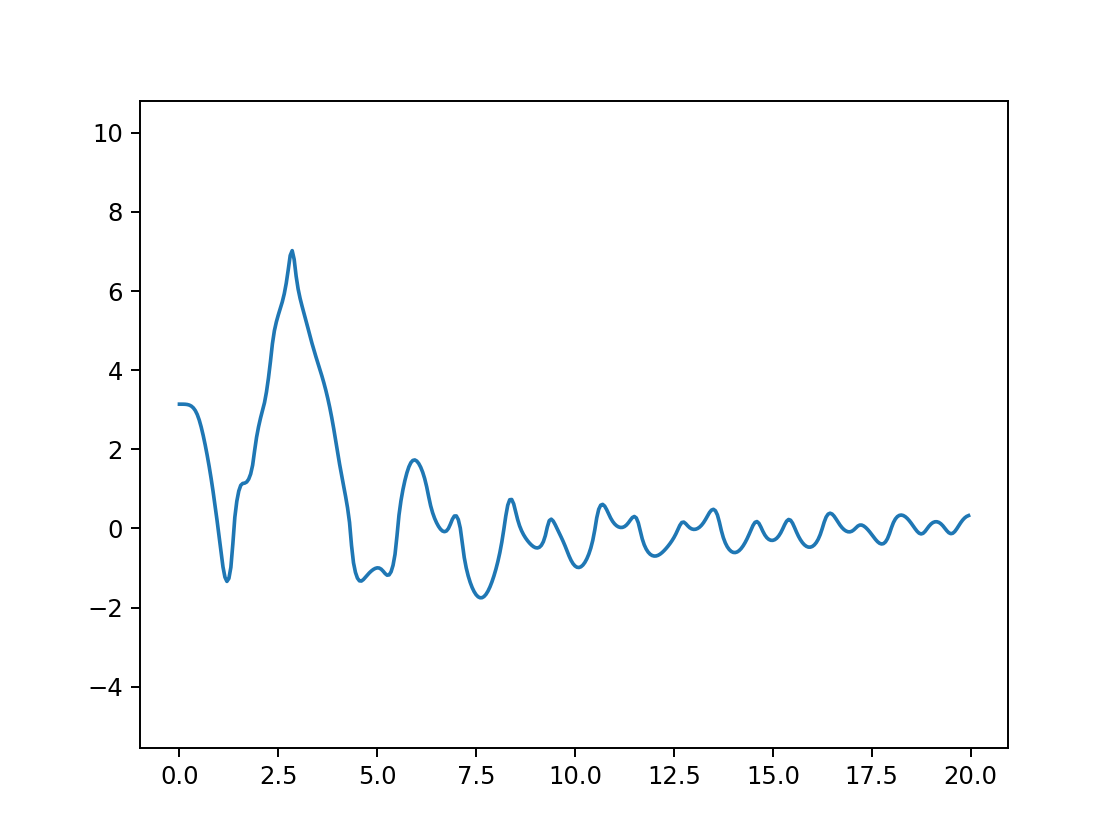

In [23]:
plot(times, res[:,1]) 
axis('equal') 
show()

Everything below I got from the matplotlib examples. Note that I had to install FFmpeg on my windows machine to get the export to work.

In [13]:
%matplotlib notebook

In [14]:
y=res

In [15]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

<IPython.core.display.Javascript object>


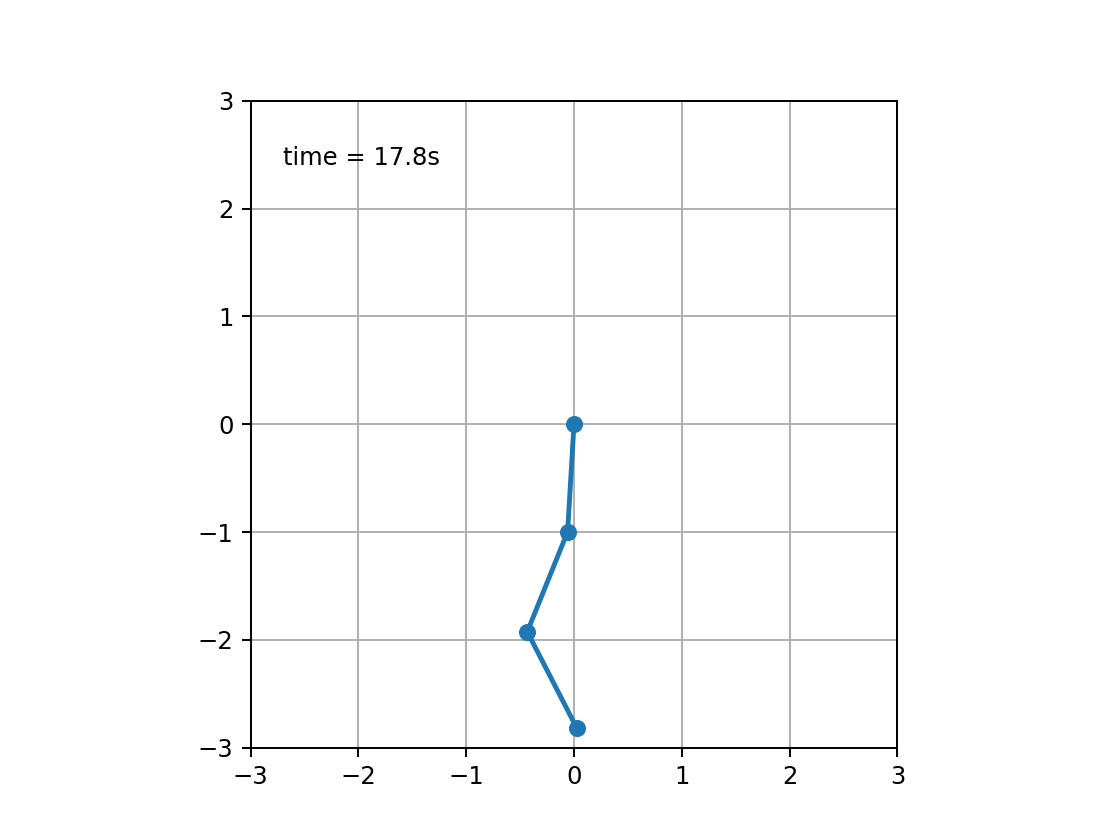

In [17]:
x1 = sin(y[:, 0])
y1 = -cos(y[:, 0])

x2 = sin(y[:, 1]) + x1
y2 = -cos(y[:, 1]) + y1

x3 = sin(y[:, 2]) + x2
y3 = -cos(y[:, 2]) + y2
fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-3, 3), ylim=(-3, 3))
ax.grid()
ax.set_aspect('equal')
line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text


def animate(i):
    thisx = [0, x1[i], x2[i], x3[i]]
    thisy = [0, y1[i], y2[i], y3[i]]

    line.set_data(thisx, thisy)
    time_text.set_text(time_template % (i*dt))
    return line, time_text

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(y)),
                              interval=150, blit=True, init_func=init)

#ani.save('double_pendulum.mp4', fps=15)
ani.save('basic_animation.mp4', fps=15, extra_args=['-vcodec', 'libx264'])
plt.show()